<a href="https://colab.research.google.com/github/LuchoVidalSMN/CursoAECID/blob/main/Pr%C3%A1ctica_N%C2%B03_Clasificaci%C3%B3n_de_ecos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

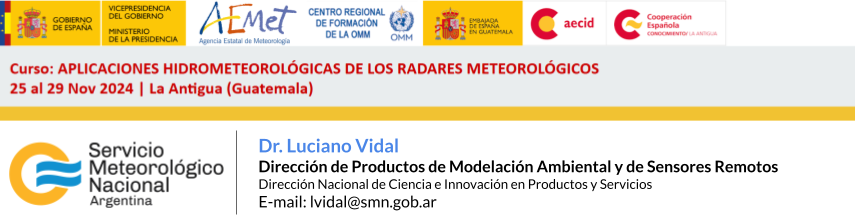

---
# **Práctica N°3:** Clasificación de ecos de radar
Clasificar los ecos de radar es una práctica común de cara a optimizar productos tales como las estimaciones cuantitativas de precipitación por citar un ejemplo. En este contexto, estos algoritmos buscan a priori identificar o separar ecos meteorologicos de no meteorologicos, para luego, dentro de los ecos meteorologicos, clasificar los pixeles con diferentes objetivos. Por ejemplo, querer separar los ecos en zonas con precipitacion convectiva o estratiforme, o zonas donde se podria estar potencialmente formando granizo.

Los algoritmos de clasificación pueden ser tan sencillos como aplicar umbrales a las variables de radar, pero para ellos no obstante es necesario conocer como responderan los diferentes ecos y asi poder elegir que umbral usar en cada caso, como tan complejos como el uso de arboles de decision y metodologias estadisticas como la lógica difusa.

El **objetivo** entonces de esta práctica es poder implementar algunas de estas clasificaciones usando los datos de radar polarimétrico.

## *¡Comencemos!* 💪
---

# **Instalación de librerías**
Si bien la herramienta Google Colaboratory trae un gran número de librerías preinstaladas, otras más específicas para el manejo de datos radar como [Py-ART](https://arm-doe.github.io/pyart/) no lo estan, y entonces tenemos que instalarlas. También algunas otras librerías que serán muy útiles al momento de graficar y querer agregar mapas y jugar con proyecciones como [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

In [ ]:
!pip install -qq --upgrade pip
!pip install -qq fsspec==2023.6.0
!pip install -qq pyproj
!pip install -qq netCDF4
!pip install -qq arm-pyart
!apt-get install -qq libgdal-dev libproj-dev
!pip install -qq --force-reinstall --no-binary shapely shapely==1.7.1
!pip install -qq cartopy==0.21
!pip install -qq glob2
!pip install -qq --user urllib3>=1.25
!pip install -qq wradlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 106.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0

# **Descarga de datos**
Para esta actividad solo utilizaremos un archivo con datos de radar en formato netCDF/CF-Radial. Vamos a descargar el archivo a trabajar y para ello vamos a usar el comando *wget*, que lo gaurdará en el disco local de la Google Colab (la nube!).

In [ ]:
# ARCHIVO FORMATO NETCDF/CF-RADIAL
file_nc = 'cfrad.20230211_204536.0000_to_20230211_205126.0000_RMA6_0217_01.nc'
!wget -O file.nc https://www.dropbox.com/scl/fi/z1jhzps3zboiu42aox67m/cfrad.20230211_204536.0000_to_20230211_205126.0000_RMA6_0217_01.nc?rlkey=hf6m6edl5os8x8somld05kpts&dl=0

--2023-11-04 20:27:26--  https://www.dropbox.com/scl/fi/z1jhzps3zboiu42aox67m/cfrad.20230211_204536.0000_to_20230211_205126.0000_RMA6_0217_01.nc?rlkey=hf6m6edl5os8x8somld05kpts
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc854358461aa12f3ff873295d0e.dl.dropboxusercontent.com/cd/0/inline/CG7MN64k8vSUSUNi5Ol-PobhE266oo1hSv9_qWq29X5Gp_5U6hpXkF5ruRLYG65CpRb7NK1mXpwaodE0amj2f5f_0ZSgwKKKekn6kxzYCb3q-Zt7uuifexkPZ9t4ECyW0RM/file# [following]
--2023-11-04 20:27:27--  https://uc854358461aa12f3ff873295d0e.dl.dropboxusercontent.com/cd/0/inline/CG7MN64k8vSUSUNi5Ol-PobhE266oo1hSv9_qWq29X5Gp_5U6hpXkF5ruRLYG65CpRb7NK1mXpwaodE0amj2f5f_0ZSgwKKKekn6kxzYCb3q-Zt7uuifexkPZ9t4ECyW0RM/file
Resolving uc854358461aa12f3ff873295d0e.dl.dropboxusercontent.com (uc854358461aa12f3ff873295d0e.dl.dropboxusercontent.com)... 162.125.

# **Importamos las librerías**

In [ ]:

import pyart
import numpy as np
from matplotlib import pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

costas = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='coastline',
                                             scale='10m',
                                             facecolor='none'
                                            )

paises = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none'
                                            )

prov   = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='10m',
                                             facecolor='none'
                                            )



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

0.2.0


# **Lectura del dato**

In [ ]:
# Creamos objeto "radar"
radar = pyart.io.read('file.nc')

# Variables disponibles
print(radar.fields.keys())

# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Elevaciones disponibles (PPI)
print(radar.fixed_angle['data'].data)

dict_keys(['DBZV', 'DBZH', 'ZDR', 'KDP', 'RHOHV', 'PHIDP'])
[ 0.55  0.9   1.3   1.78  2.26  3.1   3.98  5.08  6.39  8.06 10.04 12.5
 15.58 20.06 29.99]


# **Visualización PPI**

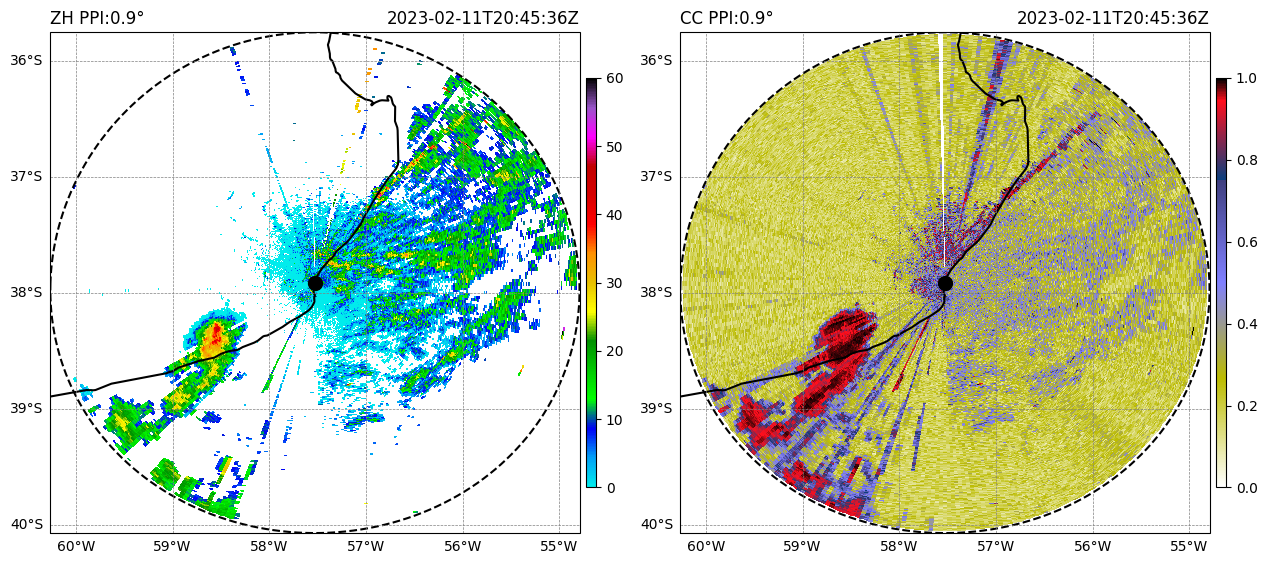

In [ ]:

#==============================================================================#

# Definimos la elevacion de interés (PPI)
NumPPI=1

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][NumPPI]
end_index   = radar.sweep_end_ray_index['data'][NumPPI]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH  = radar.fields['DBZH']['data'][start_index:end_index, :]
RHO = radar.fields['RHOHV']['data'][start_index:end_index, :]

#==============================================================================#

rmax=240.0
R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

#==============================================================================#

fig, ax = plt.subplots(1, 2, figsize=(14,7), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=1e-10, hspace=0.15)

#==============================================================================#
#==========                REFLECTIVIDAD HORIZONTAL                  ==========#
#==============================================================================#

im=ax[0][0].pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar(im, ax=ax[0][0], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][0].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][0].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][0].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][0].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][0].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][0].set_title('ZH PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][0].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][0].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][0].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][0].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#
#==========              COEF. DE CORRELACION CO-POLAR               ==========#
#==============================================================================#

im=ax[0][1].pcolormesh(lons_rad, lats_rad, RHO, vmin=0, vmax=1, cmap='gist_stern_r')
plt.colorbar(im, ax=ax[0][1], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][1].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][1].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][1].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][1].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][1].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][1].set_title('CC PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][1].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][1].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][1].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][1].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#

# Guardamos la figura
#plt.savefig('ejemplo.png', transparent=False, bbox_inches='tight')

plt.show()


# **Clasificación usando umbrales**
¿Qué pasa si utilizamos una única variable?

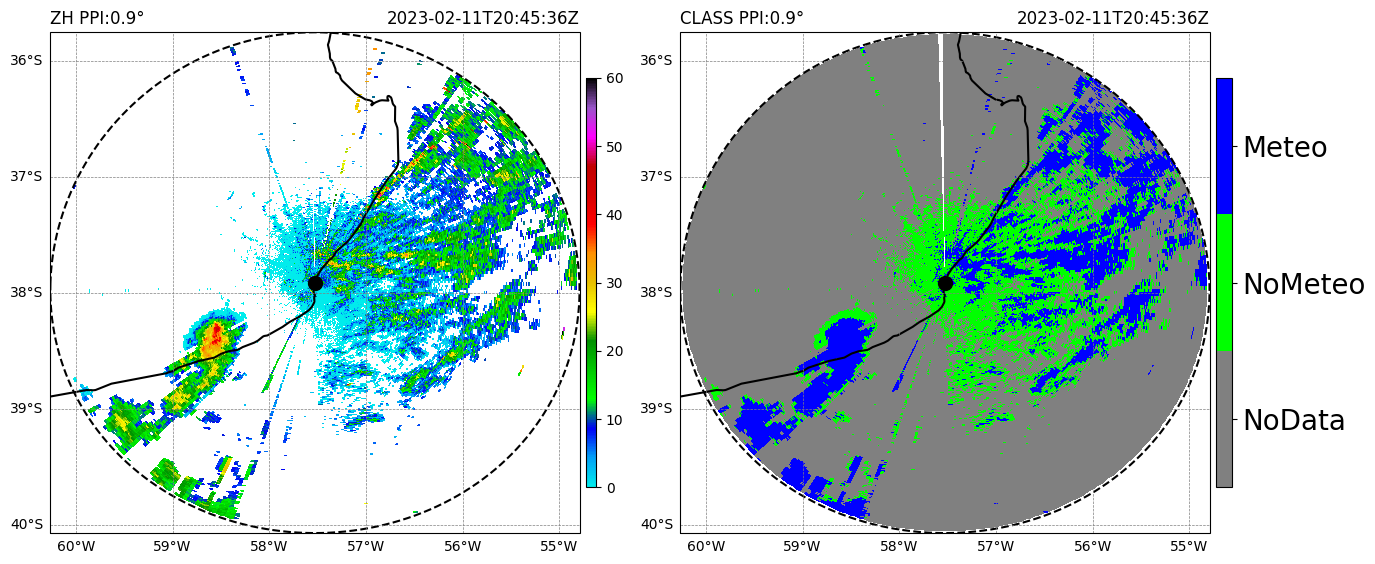

In [ ]:

#==============================================================================#

# Definimos la elevacion de interés (PPI)
NumPPI=1

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][NumPPI]
end_index   = radar.sweep_end_ray_index['data'][NumPPI]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH  = radar.fields['DBZH']['data'][start_index:end_index, :]
RHO = radar.fields['RHOHV']['data'][start_index:end_index, :]

#==============================================================================#

# DEFINIMOS CLASIFICACION
CLASS = np.copy(ZH.data)*0
CLASS[ZH.data>=10]=2 # -> Eco meteorologico
CLASS[ (ZH.data>-100) & (ZH.data<10) ]=1 # -> Eco no meteorologico

#==============================================================================#

fig, ax = plt.subplots(1, 2, figsize=(14,7), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=1e-10, hspace=0.15)

#==============================================================================#
#==========                REFLECTIVIDAD HORIZONTAL                  ==========#
#==============================================================================#

im=ax[0][0].pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar(im, ax=ax[0][0], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][0].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][0].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][0].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][0].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][0].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][0].set_title('ZH PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][0].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][0].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][0].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][0].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#
#==========                     CLASIFICACION                        ==========#
#==============================================================================#

from matplotlib import colors
cmap = colors.ListedColormap(['gray', 'lime', 'blue'])
bounds=[0,1,2,3]
ticks  = (np.array(bounds[:-1])+np.array(bounds[1:]))/2
labels = ['NoData', 'NoMeteo', 'Meteo']

im=ax[0][1].pcolormesh(lons_rad, lats_rad, CLASS, vmin=0, vmax=3, cmap=cmap)
cbar = plt.colorbar(im, ax=ax[0][1], aspect=25, pad=0.01, shrink=0.65)
cbar.ax.tick_params(axis='y', right='off', labelsize=20)
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

# Agregamos mapa limites politicos
ax[0][1].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][1].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][1].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][1].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][1].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][1].set_title('CLASS PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][1].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][1].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][1].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][1].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#

# Guardamos la figura
#plt.savefig('ejemplo.png', transparent=False, bbox_inches='tight')

plt.show()


Para mejorar el desempeño de nuestro algoritmo de clasificación una cosa que podemos hacer es utilizar las dos variables *reflectividad* y *coeficiente de correlación co-polar*. Luego, los umbrales de cada una o bien podemos recurrir a la bibliografío o la inspeccion visual de los PPI, o también analizar un diagrama de dispersión.

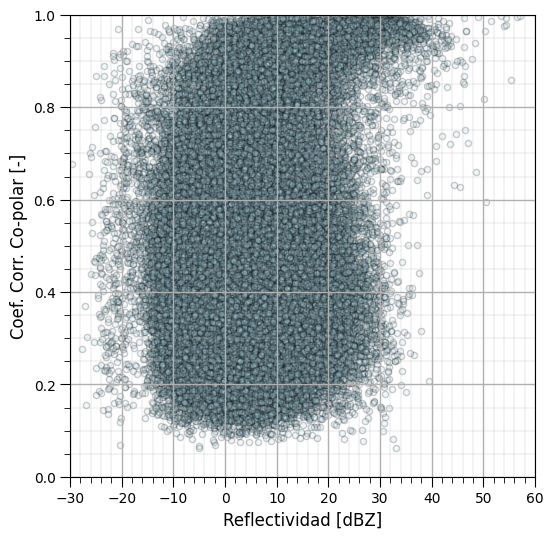

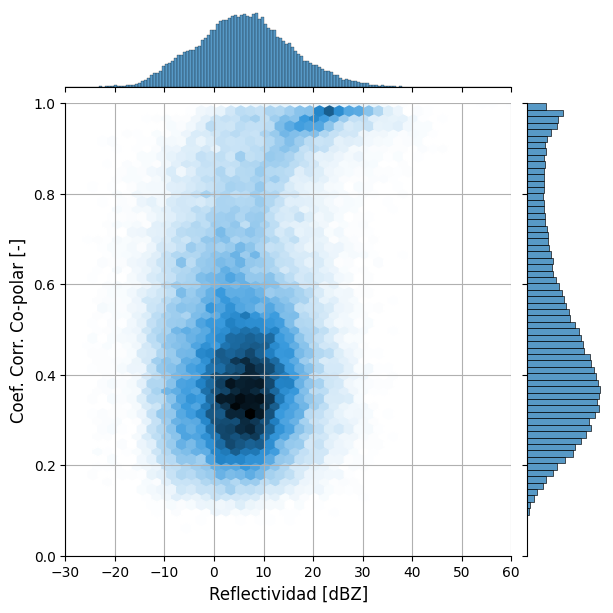

In [ ]:

import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, AutoLocator)

ZHflat  = np.reshape(ZH, (np.product(ZH.shape),))
RHOflat = np.reshape(RHO, (np.product(RHO.shape),))

plt.figure(figsize=[6,6])
plt.subplot(111)
plt.scatter(ZHflat,RHOflat, c='lightblue', s=20, alpha=0.2, edgecolor='black')
plt.xlabel('Reflectividad [dBZ]', fontsize=12)
plt.ylabel('Coef. Corr. Co-polar [-]', fontsize=12)
plt.xlim(-30,60)
plt.ylim(0,1)
plt.gca().grid(True, which='major',linewidth = 1.0)
plt.gca().grid(True, which='minor',linewidth = 0.2)
plt.gca().tick_params(which='major',length=7)
plt.gca().tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

sns.jointplot(x=ZHflat, y=RHOflat, kind='hex')
plt.xlabel('Reflectividad [dBZ]', fontsize=12)
plt.ylabel('Coef. Corr. Co-polar [-]', fontsize=12)
plt.xlim(-30,60)
plt.ylim(0,1)
plt.grid()

plt.show()


¿Dónde se ubican en la imagen?

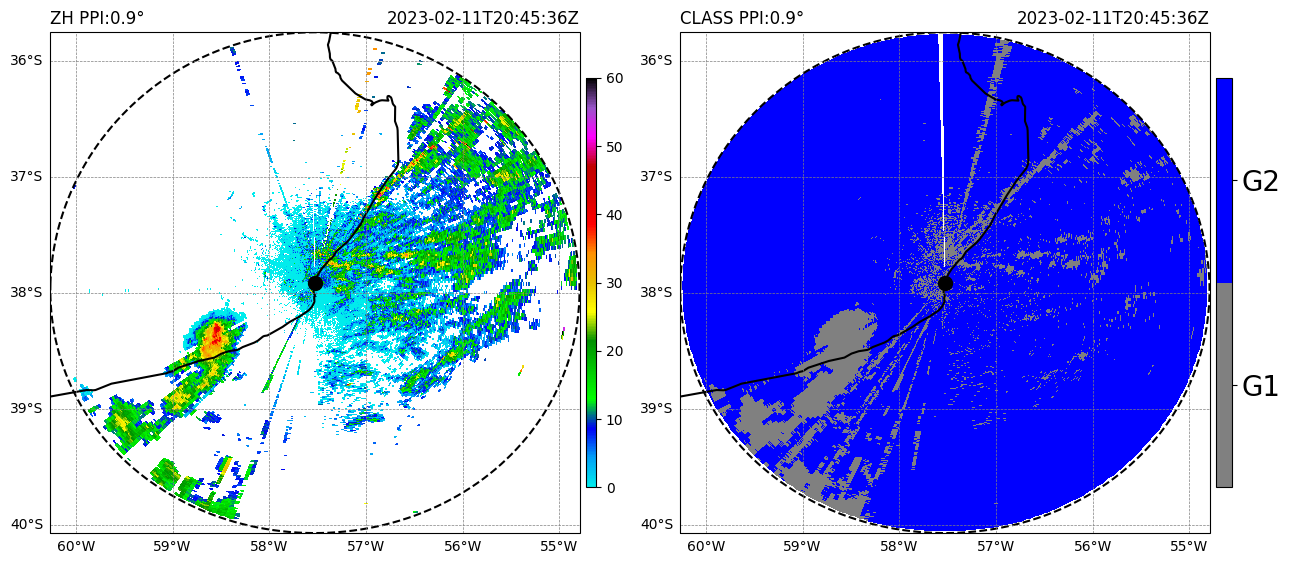

In [ ]:

#==============================================================================#

# DEFINIMOS CLASIFICACION
CLASS = np.copy(ZH)*0
CLASS[ (ZH<20) & (RHO<0.6) ]=1

#==============================================================================#

fig, ax = plt.subplots(1, 2, figsize=(14,7), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=1e-10, hspace=0.15)

#==============================================================================#
#==========                REFLECTIVIDAD HORIZONTAL                  ==========#
#==============================================================================#

im=ax[0][0].pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar(im, ax=ax[0][0], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][0].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][0].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][0].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][0].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][0].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][0].set_title('ZH PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][0].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][0].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][0].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][0].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#
#==========                     CLASIFICACION                        ==========#
#==============================================================================#

from matplotlib import colors
cmap = colors.ListedColormap(['gray', 'blue'])
bounds=[0,0.5,1]
ticks  = (np.array(bounds[:-1])+np.array(bounds[1:]))/2
labels = ['G1', 'G2']

im=ax[0][1].pcolormesh(lons_rad, lats_rad, CLASS, vmin=0, vmax=1, cmap=cmap)
cbar = plt.colorbar(im, ax=ax[0][1], aspect=25, pad=0.01, shrink=0.65)
cbar.ax.tick_params(axis='y', right='off', labelsize=20)
cbar.set_ticks(ticks)
cbar.set_ticklabels(labels)

# Agregamos mapa limites politicos
ax[0][1].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][1].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][1].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][1].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][1].set_title(radar.time['units'][14:], fontsize=12, loc='right')
ax[0][1].set_title('CLASS PPI:'+str(radar.fixed_angle['data'][NumPPI])+'°', fontsize=12, loc='left')

ax[0][1].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][1].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][1].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][1].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

#==============================================================================#

# Guardamos la figura
#plt.savefig('ejemplo.png', transparent=False, bbox_inches='tight')

plt.show()
